# Logistic Regression as a Neural Network 
(partly following deeplearning.ai lab)

    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 


In [56]:
import random
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
% matplotlib inline

UsageError: Line magic function `%` not found.


## General Architecture of the algorithm ##


Build a Logistic Regression, using a Neural Network mindset.

**Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

**Key steps**:
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## Parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features, number of layers, number of neurons in the layer etc.) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

Build 1-3 separately and integrate them into one function we call `model()`.

### Sigmoid

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 

In [2]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / (1. + np.exp(-z))

    return s

In [3]:
print("sigmoid([0, 2, 10, -10]) = " + str(sigmoid(np.array([0., 2., -2., 100.]))))

sigmoid([0, 2, 10, -10]) = [0.5        0.88079708 0.11920292 1.        ]


### Initializing parameters



In [4]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim, 1))
    b = 0.

    return w, b

In [5]:
dim = 3
w, b = initialize_with_zeros(dim)
print("w = " + str(w))
print("b = " + str(b))

w = [[0.]
 [0.]
 [0.]]
b = 0.0


### Forward and Backward propagation

Implement a function `propagate()` that computes the cost function and its gradient.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we should use: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [6]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = -(1. / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A), axis=1)  # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1. / m) * np.dot(X, (A - Y).T)
    db = (1. / m) * np.sum(A - Y, axis=1)

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [7]:
w, b, X, Y = np.array([[1.], [-1.]]), 4., np.array([[1., 5., -1.], [10., 0., -3.2]]), np.array([[0, 1, 1]])
grads, cost = propagate(w, b, X, Y)
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
print("cost = " + str(cost))

dw = [[0.0027004 ]
 [0.02446984]]
db = [0.00151471]
cost = [0.00295537]


### Optimization
- We have initialized the parameters.
- We are able to compute a cost function and its gradient.
- Now, we have to update the parameters using gradient descent.

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [46]:
# optimize

def optimize_gd(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w -= learning_rate * dw
        b -= learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [47]:
params, grads, costs = optimize_gd(w, b, X, Y, num_iterations=1000, learning_rate=0.005, print_cost=True)

print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))

Cost after iteration 0: 0.824838
Cost after iteration 100: 0.470206
Cost after iteration 200: 0.338820
Cost after iteration 300: 0.272989
Cost after iteration 400: 0.232216
Cost after iteration 500: 0.203700
Cost after iteration 600: 0.182243
Cost after iteration 700: 0.165311
Cost after iteration 800: 0.151502
Cost after iteration 900: 0.139966
w = [[-1.41112627]
 [ 0.32144815]]
b = [-0.29088205]
dw = [[ 0.13300869]
 [-0.00230662]]
db = [0.02262338]


Implement the `predict()` function. There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`. 

In [10]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0, i] <= 0.5):
            Y_prediction[0][i] = 0
        else:
            Y_prediction[0][i] = 1

    return Y_prediction

In [11]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2], [1.2, 2., 0.1]])
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]



Already have:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## Merge it all into a model ##

    - Y_prediction_test for the predictions on the test set
    - Y_prediction_train for the predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [48]:
# model

def model(X_train, Y_train, X_test, Y_test, optimize: Callable, num_iterations=2000, learning_rate=0.5,
          print_cost=False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}

    return d

Run the following cell to train your model.

1.	Apply the logistic regression method using the functions in the notebook «Logistic Regression as a Neural Network – BP alg.ipynb” to predict the biological response of a molecule data. Use 75% of the dataset to train the model, and the rest of the data to estimate its accuracy.

In [40]:
data = pd.read_csv("bioresponse.csv")

In [43]:
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(data.drop("Activity", axis=1),
                                                                    data["Activity"],
                                                                    test_size=0.25,
                                                                    random_state=0)

In [65]:
d_gd = model(train_set_x.to_numpy().T, train_set_y.to_numpy().T, test_set_x.to_numpy().T, test_set_y.to_numpy().T,
             optimize=optimize_gd, num_iterations=2000, learning_rate=0.001, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.678956
Cost after iteration 200: 0.671388
Cost after iteration 300: 0.664732
Cost after iteration 400: 0.658592
Cost after iteration 500: 0.652883
Cost after iteration 600: 0.647550
Cost after iteration 700: 0.642549
Cost after iteration 800: 0.637844
Cost after iteration 900: 0.633404
Cost after iteration 1000: 0.629203
Cost after iteration 1100: 0.625219
Cost after iteration 1200: 0.621434
Cost after iteration 1300: 0.617828
Cost after iteration 1400: 0.614389
Cost after iteration 1500: 0.611102
Cost after iteration 1600: 0.607956
Cost after iteration 1700: 0.604939
Cost after iteration 1800: 0.602044
Cost after iteration 1900: 0.599260
train accuracy: 72.23604692499111 %
test accuracy: 68.7633262260128 %


Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/


### SGD

2.	Modify optimize() function to implement the stochastic gradient descent (SGD) method. Apply it to solve the problem from p.1.

In [82]:
def optimize_sgd(w, b, X, Y, num_iterations, learning_rate, print_cost=False, batch_size=32):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """
    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        rands = random.sample(range(len(X)), batch_size)
        grads, cost = propagate(w, b, X[:, rands], Y[rands])

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w -= learning_rate * dw
        b -= learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [83]:
d_sgd = model(train_set_x.to_numpy().T, train_set_y.to_numpy().T, test_set_x.to_numpy().T, test_set_y.to_numpy().T,
              optimize=optimize_sgd, num_iterations=2000, learning_rate=0.001, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.698583
Cost after iteration 200: 0.636087
Cost after iteration 300: 0.689954
Cost after iteration 400: 0.615459
Cost after iteration 500: 0.677631
Cost after iteration 600: 0.652635
Cost after iteration 700: 0.595363
Cost after iteration 800: 0.673706
Cost after iteration 900: 0.648994
Cost after iteration 1000: 0.603289
Cost after iteration 1100: 0.651161
Cost after iteration 1200: 0.579909
Cost after iteration 1300: 0.615006
Cost after iteration 1400: 0.602621
Cost after iteration 1500: 0.606652
Cost after iteration 1600: 0.604941
Cost after iteration 1700: 0.609025
Cost after iteration 1800: 0.610766
Cost after iteration 1900: 0.599531
train accuracy: 72.9825808745112 %
test accuracy: 69.18976545842217 %


3.	For two modifications of gradient descent (pp. 1 and 2), plot the learning curves (dependence of the value of the loss function on the iteration number), apply models with different values of the learning rate (at least 5 different learning rates). How does it affect the accuracy of the model?

In [76]:
def print_compare_gd_and_sgd_plot(lr, num_iterations=2000) -> None:
    d_gd = model(train_set_x.to_numpy().T, train_set_y.to_numpy().T, test_set_x.to_numpy().T, test_set_y.to_numpy().T,
                 optimize=optimize_gd, num_iterations=num_iterations, learning_rate=lr, print_cost=False)
    d_sgd = model(train_set_x.to_numpy().T, train_set_y.to_numpy().T, test_set_x.to_numpy().T, test_set_y.to_numpy().T,
                  optimize=optimize_sgd, num_iterations=num_iterations, learning_rate=lr, print_cost=False)
    plt.figure(figsize=(7, 5))
    plt.plot(range(0, num_iterations, 100), d_gd['costs'], label="GD")
    plt.plot(range(0, num_iterations, 100), d_sgd['costs'], label="SGD")
    plt.title(f'Compare GD and SGD; lr={lr}', fontsize=15)
    plt.xlabel('iteration', fontsize=12)
    plt.ylabel('cost', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

train accuracy: 79.34589406327764 %
test accuracy: 75.3731343283582 %
train accuracy: 78.88375399928901 %
test accuracy: 74.6268656716418 %


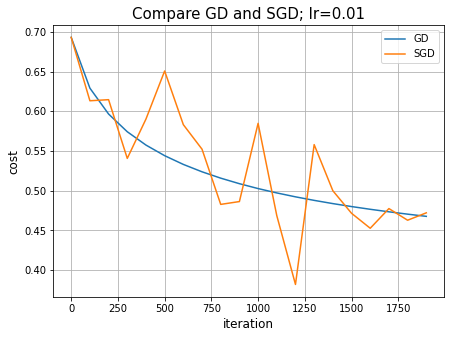

train accuracy: 72.23604692499111 %
test accuracy: 68.7633262260128 %
train accuracy: 73.26697476004266 %
test accuracy: 68.5501066098081 %


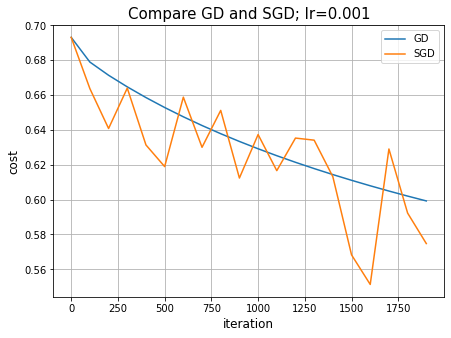

train accuracy: 56.843227870600785 %
test accuracy: 58.2089552238806 %
train accuracy: 56.061144685389266 %
test accuracy: 56.82302771855011 %


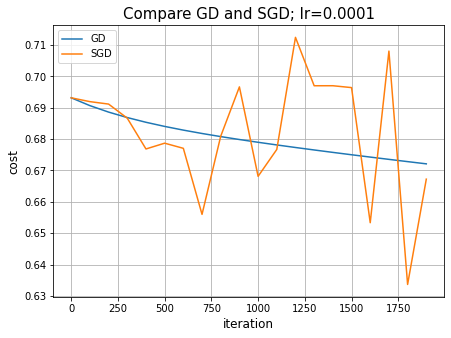

train accuracy: 54.0348382509776 %
test accuracy: 54.79744136460554 %
train accuracy: 54.0348382509776 %
test accuracy: 54.79744136460554 %


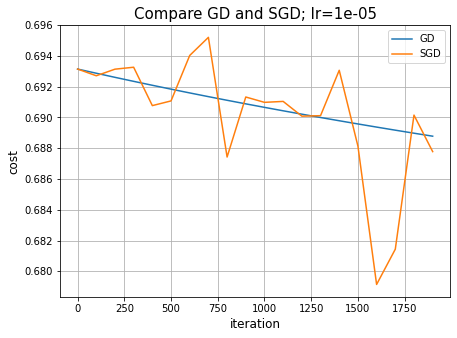

train accuracy: 54.0348382509776 %
test accuracy: 54.79744136460554 %
train accuracy: 54.0348382509776 %
test accuracy: 54.79744136460554 %


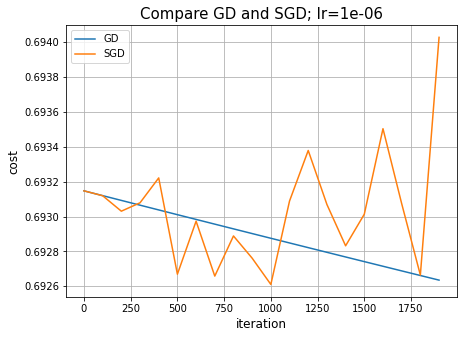

In [78]:
for lr in [0.01, 0.001, 0.0001, 0.00001, 0.000001]:
    print_compare_gd_and_sgd_plot(lr)

#### How different values of the learning rate affect the accuracy of the model?

Then greater lr, then higher the accuracy. This is due to the fact that the optimizer moves more actively towards the gradient, and in the first iterations of training this is more important.

4.	Implement the Adam optimization method using the numpy library and compare the accuracy of the model fitted with it with the models trained by the classic GD and SGD algorithms.

In [92]:
def optimize_adam(w: np.ndarray, b: float, X, Y, num_iterations, learning_rate, print_cost=False, beta1: float = 0.9, beta2: float = 0.999):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """
    costs = []
    velocity = np.zeros(w.shape)
    accumulated = np.zeros(w.shape)
    velocity_db = 0
    accumulated_db = 0

    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        velocity = beta1 * velocity + (1 - beta1) * dw
        accumulated = beta2 * accumulated + (1 - beta2) * dw ** 2
        adaptive_lr = np.nan_to_num(learning_rate / np.sqrt(accumulated))
        w = w - adaptive_lr * velocity

        velocity_db = beta1 * velocity_db + (1 - beta1) * db
        accumulated_db = beta2 * accumulated_db + (1 - beta2) * db ** 2
        adaptive_lr_b = np.nan_to_num(learning_rate / np.sqrt(accumulated_db))
        b = b - adaptive_lr_b * velocity_db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [93]:
d_adam = model(train_set_x.to_numpy().T, train_set_y.to_numpy().T, test_set_x.to_numpy().T, test_set_y.to_numpy().T,
              optimize=optimize_adam, num_iterations=2000, learning_rate=0.001, print_cost=True)

/var/folders/39/sbhbfb514339n_2mzhldqjm40000gn/T/ipykernel_25769/3154485601.py:38: RuntimeWarning: divide by zero encountered in true_divide
  adaptive_lr = np.nan_to_num(learning_rate / np.sqrt(accumulated))


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.382787
Cost after iteration 200: 0.345223
Cost after iteration 300: 0.324298
Cost after iteration 400: 0.309738
Cost after iteration 500: 0.298541
Cost after iteration 600: 0.289417
Cost after iteration 700: 0.281694
Cost after iteration 800: 0.274977
Cost after iteration 900: 0.269014
Cost after iteration 1000: 0.263636
Cost after iteration 1100: 0.258726
Cost after iteration 1200: 0.254196
Cost after iteration 1300: 0.249983
Cost after iteration 1400: 0.246037
Cost after iteration 1500: 0.242319
Cost after iteration 1600: 0.238798
Cost after iteration 1700: 0.235450
Cost after iteration 1800: 0.232255
Cost after iteration 1900: 0.229195
train accuracy: 90.65055101315322 %
test accuracy: 73.98720682302772 %


train accuracy: 72.23604692499111 %
test accuracy: 68.7633262260128 %
train accuracy: 73.19587628865979 %
test accuracy: 69.40298507462687 %


/var/folders/39/sbhbfb514339n_2mzhldqjm40000gn/T/ipykernel_25769/3154485601.py:38: RuntimeWarning: divide by zero encountered in true_divide
  adaptive_lr = np.nan_to_num(learning_rate / np.sqrt(accumulated))


train accuracy: 90.65055101315322 %
test accuracy: 73.98720682302772 %


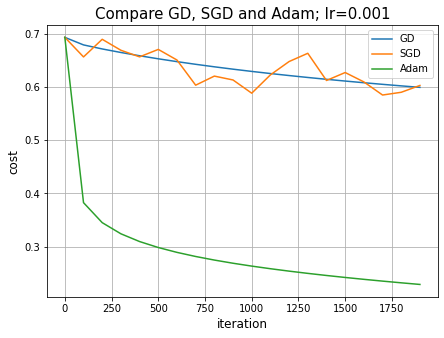

In [96]:
lr = 0.001
num_iterations = 2000
d_gd = model(train_set_x.to_numpy().T, train_set_y.to_numpy().T, test_set_x.to_numpy().T, test_set_y.to_numpy().T,
                optimize=optimize_gd, num_iterations=num_iterations, learning_rate=lr, print_cost=False)
d_sgd = model(train_set_x.to_numpy().T, train_set_y.to_numpy().T, test_set_x.to_numpy().T, test_set_y.to_numpy().T,
              optimize=optimize_sgd, num_iterations=num_iterations, learning_rate=lr, print_cost=False)
d_adam = model(train_set_x.to_numpy().T, train_set_y.to_numpy().T, test_set_x.to_numpy().T, test_set_y.to_numpy().T,
             optimize=optimize_adam, num_iterations=num_iterations, learning_rate=lr, print_cost=False)
plt.figure(figsize=(7, 5))
plt.plot(range(0, num_iterations, 100), d_gd['costs'], label="GD")
plt.plot(range(0, num_iterations, 100), d_sgd['costs'], label="SGD")
plt.plot(range(0, num_iterations, 100), d_adam['costs'], label="Adam")
plt.title(f'Compare GD, SGD and Adam; lr={lr}', fontsize=15)
plt.xlabel('iteration', fontsize=12)
plt.ylabel('cost', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

As you can see from the plot, Adam allows to optimize model much faster than GD and SGD.